In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd

from tqdm import tqdm
from bs4 import BeautifulSoup
from utils import *

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

tqdm.pandas(desc="Preprocess dataset")
%matplotlib inline

logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

In [3]:
import json
import os
from gensim.models.phrases import Phrases
from glove import GloveDataset, GloveModel
from glove.torch_glove_utils import generate_batches
from glove.torch_glove_model import train, WordVector
from argparse import Namespace

In [4]:
args = Namespace(
    data_path = "data/data.json",
    embedding_dim = 50,
    cuda = True,
    x_max = 100,
    alpha = 0.75,
    batch_size = int(2**10),
    learning_rate = 0.001,
    model_state_file="model.pth",
    save_dir="model_storage"
)
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
args.model_state_file = os.path.join(args.save_dir,
                                args.model_state_file)

# handle dirs
handle_dirs(args.save_dir)

# Load Data

In [5]:
docs = json.load(open(args.data_path, "r"))
print(docs[0])

why scalability matters for your app Building an app is an extensive process. From a fresh idea to a marketable product, the journey is filled with ups and downs. So, when you (hopefully) build that successful app, the last thing you want is for it to hit a dead end.
However, that’s, unfortunately, the way it usually goes. You might think that accelerated growth is totally positive, as users are downloading your app at a record rate. But, an app that isn’t designed and developed to seamlessly handle this explosive growth will eventually end up being a failure.
Consider this: is your app, as it stands today, able to scale up to exponential growth? If you have any doubts, you need to seriously consider this scalability issue.

What is app scalability?
Scalability is the ability of your app to handle a growing number of customers, clients and/or users. It also pertains to the ability of your current or future developer to maintain the app. Consider the possibility that your app isn’t curr

# Preprocess for training

In [6]:
regex = get_regex_expression()
regex

'(https?:\\/\\/.*[\\r\\n])|(\\#[^\\s]*)|(\\@[^\\s]*)|(author)|(\\S*@\\S+)|([^a-zA-Z0-9À-ÿ\\u00f1\\u00d1\\s])'

In [7]:
example = preprocess_data(docs[0], regex, 
                          removing_stops=True, lemmatize=True)
print(example)

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build', 'successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerate', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive', 'growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run', 's

In [8]:
# Train data doing lemmatization and removing stopswords
train_data = [preprocess_data(normalize_data, regex, True, True) 
                for normalize_data in tqdm(docs)]

100%|██████████| 485/485 [00:49<00:00,  9.71it/s]


# Create Bigrams

In [9]:
bigrams = Phrases(train_data, threshold=5)

2020-08-01 09:38:51,575 : INFO : collecting all words and their counts
2020-08-01 09:38:51,576 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-08-01 09:38:51,900 : INFO : collected 167215 word types from a corpus of 238684 words (unigram + bigrams) and 485 sentences
2020-08-01 09:38:51,900 : INFO : using 167215 counts as vocab in Phrases<0 vocab, min_count=5, threshold=5, max_vocab_size=40000000>


In [10]:
import pickle
pickle.dump(bigrams, open("model_storage/bigrams.pickle", "wb"))

In [11]:
docs = list(bigrams[train_data])

In [12]:
print(docs[0])

['scalability', 'matter', 'app', 'build', 'app', 'extensive', 'process', 'fresh', 'idea', 'marketable', 'product', 'journey', 'fill', 'up', 'down', 'hopefully', 'build_successful', 'app', 'thing', 'want', 'hit', 'dead', 'end', 'unfortunately', 'way', 'usually', 'go', 'think', 'accelerate', 'growth', 'totally', 'positive', 'user', 'download', 'app', 'record', 'rate', 'app', 'isn', 'design', 'develop', 'seamlessly', 'handle', 'explosive_growth', 'eventually', 'end', 'failure', 'consider', 'app', 'stand', 'today', 'able', 'scale', 'exponential', 'growth', 'doubt', 'need', 'seriously', 'consider', 'scalability', 'issue', 'app', 'scalability', 'scalability', 'ability', 'app', 'handle', 'grow', 'number', 'customer', 'client', 'user', 'pertain', 'ability', 'current', 'future', 'developer', 'maintain', 'app', 'consider', 'possibility', 'app', 'isn', 'currently', 'scalable', 'prepared', 'scramble', 'add', 'necessary', 'additional', 'feature', 'flexible', 'coding', 'keep', 'app', 'run_smoothly',

# Build Coocurrence matrix

In [13]:
glove_dataset = GloveDataset((10, 10))
glove_dataset.fit_to_corpus(docs)

2020-08-01 09:38:52,711 : INFO : Building coocurrence frequency dictionary distance weights
2020-08-01 09:38:52,723 : INFO : Progress: 0
2020-08-01 09:38:53,149 : INFO : Progress: 100
2020-08-01 09:38:53,802 : INFO : Progress: 200
2020-08-01 09:38:54,288 : INFO : Progress: 300
2020-08-01 09:38:54,947 : INFO : Progress: 400


# Model configurations

In [14]:
import torch

args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.epochs = 100

if args.device == 'cuda':
    args.cuda = True
else:
    args.cuda = False
    
args.total = glove_dataset.get_num_batches(batch_size=args.batch_size)

In [15]:
vars(args)

{'data_path': 'data/data.json',
 'embedding_dim': 50,
 'cuda': False,
 'x_max': 100,
 'alpha': 0.75,
 'batch_size': 1024,
 'learning_rate': 0.001,
 'model_state_file': 'model_storage/model.pth',
 'save_dir': 'model_storage',
 'device': device(type='cuda'),
 'epochs': 100,
 'total': 2030}

# Define Model and Train

In [16]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'loss': [],
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [17]:
from tqdm.notebook import tqdm as tqdm_notebook
import torch.optim as optim

model = GloveModel(
    vocab_size=len(glove_dataset.vocab),
    embedding_dim=args.embedding_dim,
    vocab=glove_dataset.vocab
).to(args.device)

optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)
print(model)
train_state

GloveModel(
  (token_embedding): Embedding(11721, 50)
  (context_embedding): Embedding(11721, 50)
  (token_bias): Embedding(11721, 1)
  (context_bias): Embedding(11721, 1)
)


{'stop_early': False,
 'early_stopping_step': 0,
 'early_stopping_best_val': 100000000.0,
 'learning_rate': 0.001,
 'epoch_index': 0,
 'loss': [],
 'model_filename': 'model_storage/model.pth'}

In [18]:
epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.epochs,
                          position=0)

train_bar = tqdm_notebook(desc='split=train',
                          total=args.total, 
                          position=1, 
                          leave=True)

try:
    for epoch_index in range(args.epochs):
        batch_generator = generate_batches(glove_dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        loss = train(batch_generator, model, optimizer, 
                     epoch_index, progress_bar=train_bar)
        train_state["loss"].append(loss)
        
        train_state = update_train_state(args=args, model=model,
                                         train_state=train_state)
        scheduler.step(train_state['loss'][-1])
        
        train_bar.n = 0
        epoch_bar.update()
        
        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")
    
word_vectors = model.__embeddings__()

# Testing similarities

In [19]:
import faiss
from faiss import normalize_L2
import numpy as np

2020-08-01 10:02:41,351 : INFO : Loading faiss with AVX2 support.


In [20]:
name = "jonathan_tarud"
vectors = word_vectors.embeddings.copy()
normalize_L2(vectors)

index = faiss.IndexFlatIP(args.embedding_dim)
index.add(vectors)

try:
    target = word_vectors[name].reshape(1, -1).copy()
    normalize_L2(target)
    D, I = index.search(target, k=6)

    for idx, dist in zip(I.squeeze()[1:], D.squeeze()[1:]):
        print(word_vectors.vocab[int(idx)] + f" {1 - dist:0.2f}")
except:
    print("Not Found")

ceo 0.34
ceo_founder 0.44
cat 0.49
carnegie 0.50
inquire 0.50


# TSNE Plot of word_embedding

In [21]:
from sklearn.manifold import TSNE
from utils import visualize_words_embedding, plots_blogs_embedding

In [22]:
matrix = word_vectors.embeddings
matrix_ = TSNE(perplexity=50, init='pca').fit_transform(matrix)
vocabulary = np.array(word_vectors.vocab.itos)

In [23]:
vocabulary[100:120]

array(['possible', 'take', 'easy', 'tool', 'increase', 'digital',
       'content', 'patient', 'issue', 'step', 'big', 'benefit', 'will',
       'plan', 'value', 'require', 'research', 'security', 'ensure',
       'learn'], dtype='<U25')

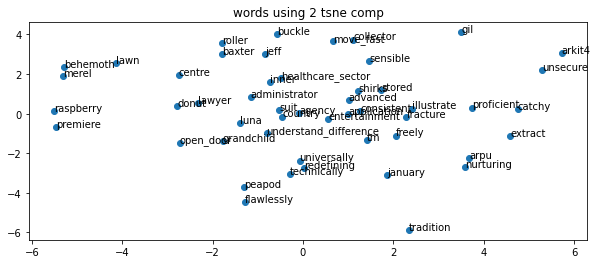

In [24]:
%matplotlib inline
visualize_words_embedding(matrix_, vocabulary, total=50, width=10, height=4)

# Save to word2vec format

In [25]:
from gensim.models import KeyedVectors
kv = KeyedVectors(50)
kv.add(word_vectors.vocab.itos, word_vectors.embeddings)
kv.save("model_storage/koombea_glove_vectors.txt")

2020-08-01 10:04:34,708 : INFO : saving Word2VecKeyedVectors object under model_storage/koombea_glove_vectors.txt, separately None
2020-08-01 10:04:34,708 : INFO : not storing attribute vectors_norm
2020-08-01 10:04:34,738 : INFO : saved model_storage/koombea_glove_vectors.txt


# Blog embedding

In [26]:
from fse.models import SIF
from fse import IndexedList

In [27]:
data_ = IndexedList(docs)
fse_model = SIF(kv, components=0, lang_freq='en')
fse_model.train(data_)

2020-08-01 10:04:34,818 : INFO : no frequency mode: using wordfreq for estimation of frequency for language: en
2020-08-01 10:04:34,902 : INFO : scanning all indexed sentences and their word counts
2020-08-01 10:04:34,903 : INFO : finished scanning 485 sentences with an average length of 450 and 218383 total words
2020-08-01 10:04:34,906 : INFO : estimated memory for 485 sentences with 50 dimensions and 11721 vocabulary: 2 MB (0 GB)
2020-08-01 10:04:34,907 : INFO : initializing sentence vectors for 485 sentences
2020-08-01 10:04:34,910 : INFO : pre-computing SIF weights for 11721 words
2020-08-01 10:04:34,917 : INFO : begin training
2020-08-01 10:04:34,953 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-01 10:04:34,953 : INFO : no removal of principal components
2020-08-01 10:04:34,954 : INFO : training on 485 effective sentences with 218383 effective words took 0s with 13557 sentences/s


(485, 218383)

In [28]:
blog_matrix = fse_model.sv.vectors
blog_matrix.shape

(485, 50)

In [29]:
import pickle
TFIDF_MATRIX = pickle.load(open("model_storage//tfidf_bigrams.pickle", "rb"))
vocab_ = pickle.load(open("model_storage/vocab_bigrams.pickle", "rb"))

In [30]:
blog_matrix_tsne = TSNE(n_components=2, init='pca').fit_transform(blog_matrix)

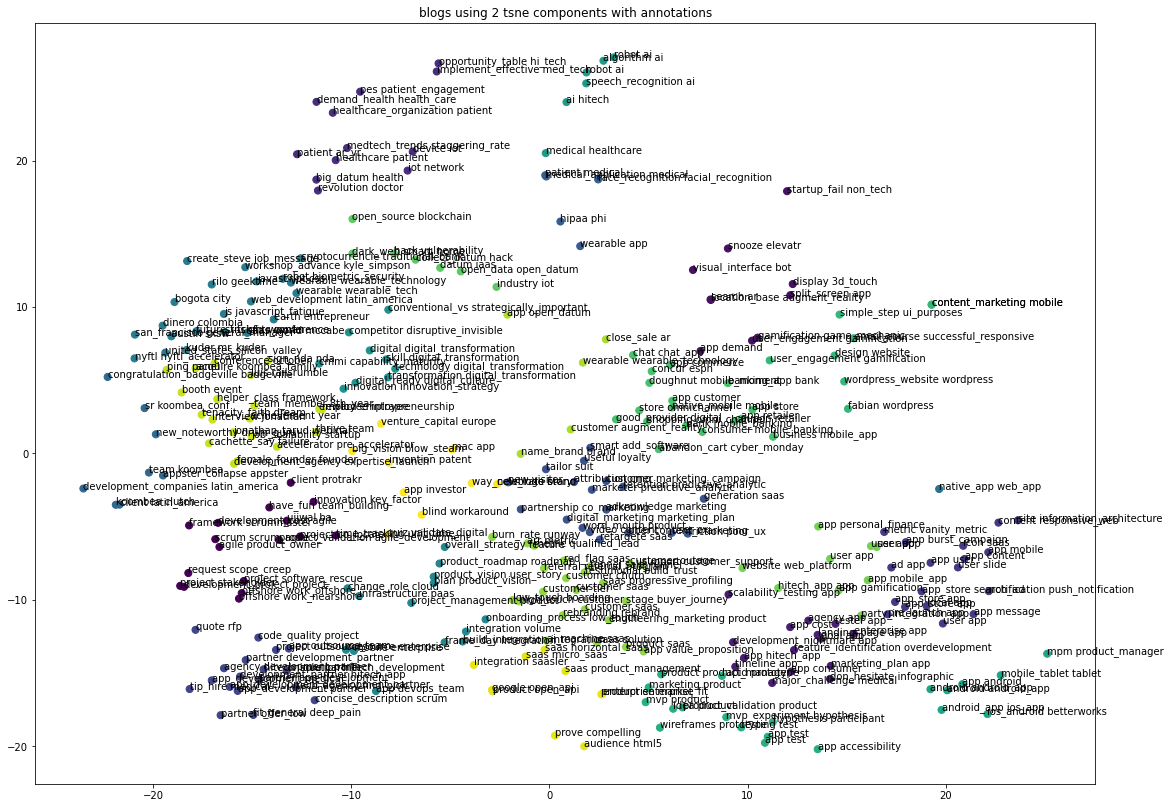

In [31]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=25).fit_predict(blog_matrix_tsne)

%matplotlib inline
plots_blogs_embedding(TFIDF_MATRIX, blog_matrix_tsne, vocab_, clusters, width=19, height=14)

# Query search

In [32]:
idx_slug = json.load(open("data/idx_to_slug.json", "r"))

In [35]:
from scipy.spatial.distance import cdist

query = "what is machine learning"
query = preprocess_data(query, regex, True, True)
query = list(bigrams[query])
query_vector = fse_model.infer([(query, 0)])

results = cdist(query_vector, fse_model.sv.vectors, 'cosine').squeeze()
results = list(enumerate(results))
results = sorted(results, key = lambda x:x[1])[:10]

for idx, score in results:
    print(idx_slug[idx])

2020-08-01 10:19:34,225 : INFO : scanning all indexed sentences and their word counts
2020-08-01 10:19:34,225 : INFO : finished scanning 1 sentences with an average length of 1 and 1 total words
2020-08-01 10:19:34,226 : INFO : no removal of principal components


7-recent-ai-developments
how-ai-is-changing-mobile-app-development
examples-ai-mobile-apps
5-uses-of-machine-learning-for-web-and-mobile-apps
6-artificial-intelligence-myths-busted
artificial-intelligence-commercial-application-ethics
catching-pop-culture-ai
what-is-machine-learning
the-differences-between-artificial-intelligence-and-machine-learning
understanding-the-7-types-of-artificial-intelligence


In [34]:
import pickle
pickle.dump(fse_model, open("model_storage/fse_model.pickle", "wb"))